In [5]:
!pip install -U imbalanced-learn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.4 MB/s eta 0:00:00


### **Data Preparation**

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import RandomizedSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')


In [8]:
# Load and Inspect Datasets
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

In [9]:
train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


In [10]:
test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1.371817e+09,33.986391,-81.200714,0.0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1.371817e+09,39.450498,-109.960431,0.0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1.371817e+09,40.495810,-74.196111,0.0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1.371817e+09,28.812398,-80.883061,0.0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1.371817e+09,44.959148,-85.884734,0.0


### **Exploratoray Data Analysis**

In [11]:
# Shape of datasets
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (42831, 23)
Testing Data Shape: (42783, 23)


In [12]:
# Columns of datasets
print("Training Data Columns:", train_df.columns)
print("Testing Data Columns:", test_df.columns)

Training Data Columns: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Testing Data Columns: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [13]:
# Info of train dataset
print("Training Data Info:")
train_df.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42831 entries, 0 to 42830
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             42831 non-null  int64  
 1   trans_date_trans_time  42831 non-null  object 
 2   cc_num                 42831 non-null  int64  
 3   merchant               42831 non-null  object 
 4   category               42831 non-null  object 
 5   amt                    42831 non-null  float64
 6   first                  42831 non-null  object 
 7   last                   42831 non-null  object 
 8   gender                 42831 non-null  object 
 9   street                 42831 non-null  object 
 10  city                   42831 non-null  object 
 11  state                  42831 non-null  object 
 12  zip                    42831 non-null  int64  
 13  lat                    42831 non-null  float64
 14  long                   42831 non-n

In [14]:
# Info of test dataset
print("\nTest Data Info:")
test_df.info()


Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42783 entries, 0 to 42782
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             42783 non-null  int64  
 1   trans_date_trans_time  42783 non-null  object 
 2   cc_num                 42783 non-null  int64  
 3   merchant               42783 non-null  object 
 4   category               42783 non-null  object 
 5   amt                    42783 non-null  float64
 6   first                  42783 non-null  object 
 7   last                   42783 non-null  object 
 8   gender                 42783 non-null  object 
 9   street                 42783 non-null  object 
 10  city                   42783 non-null  object 
 11  state                  42783 non-null  object 
 12  zip                    42783 non-null  int64  
 13  lat                    42783 non-null  float64
 14  long                   42783 non-null

In [15]:
#  Check available columns
print("Training columns:", train_df.columns.tolist())
print("Testing columns:", test_df.columns.tolist())

Training columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']
Testing columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [16]:
# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())


Missing values in training data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 1
job                      1
dob                      1
trans_num                1
unix_time                1
merch_lat                1
merch_long               1
is_fraud                 1
dtype: int64


In [17]:
# Check class distribution
print("\nClass distribution - Training:")
print(train_df['is_fraud'].value_counts(normalize=True))
print("\nClass distribution - Testing:")
print(test_df['is_fraud'].value_counts(normalize=True))


Class distribution - Training:
is_fraud
0.0    0.990731
1.0    0.009269
Name: proportion, dtype: float64

Class distribution - Testing:
is_fraud
0.0    0.995699
1.0    0.004301
Name: proportion, dtype: float64


In [18]:
# Identify target column (modify this based on actual column name)
# Common alternatives: 'isFraud', 'fraud', 'label', 'target', 'transactionStatus'
target_column = 'isFraud'  # CHANGE THIS TO YOUR ACTUAL TARGET COLUMN NAME

In [19]:
# Check for duplicates
print("\nDuplicate rows in training:", train_df.duplicated().sum())
print("Duplicate rows in testing:", test_df.duplicated().sum())


Duplicate rows in training: 0
Duplicate rows in testing: 0


In [20]:
# Analyze numerical features
num_cols = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
train_df[num_cols].describe()

,amt,city_pop,lat,long,merch_lat,merch_long
count,42831.000000,4.283000e+04,42831.000000,42831.000000,42830.000000,42830.000000
mean,71.563338,8.852743e+04,38.536225,-90.241386,38.536078,-90.247263
std,151.062206,2.977794e+05,5.091000,13.953112,5.121287,13.962830
min,1.000000,2.300000e+01,20.027100,-165.672300,19.040141,-166.629875
25%,9.690000,7.430000e+02,34.668900,-96.809400,34.785872,-96.940941
50%,47.970000,2.456000e+03,39.346500,-87.456900,39.348741,-87.366152
75%,83.680000,2.047800e+04,41.846700,-80.128400,41.924197,-80.174018
max,11872.210000,2.906700e+06,65.689900,-12.000000,66.659242,-66.967742


In [21]:
# Analyze categorical features
cat_cols = ['category', 'gender', 'state', 'job']
for col in cat_cols:
    print(f"\n{col} distribution:")
    print(train_df[col].value_counts().head())


category distribution:
category
gas_transport    4298
home             4095
grocery_pos      4069
shopping_pos     3857
kids_pets        3669
Name: count, dtype: int64

gender distribution:
gender
F    23373
M    19458
Name: count, dtype: int64

state distribution:
state
TX    3095
NY    2764
PA    2590
CA    1832
MI    1549
Name: count, dtype: int64

job distribution:
job
Exhibition designer           306
Surveyor, land/geomatics      293
Film/video editor             293
Systems developer             286
Designer, ceramics/pottery    273
Name: count, dtype: int64


### **Data Validation**

In [22]:
def validate_data(df, dataset_name):
    print(f"\n===== {dataset_name.upper()} DATA VALIDATION =====")

    # 1. Check target variable

    ## Check for missing values
    print(f"Missing values in target: {df['is_fraud'].isnull().sum()}")
    ## Check for unique values
    print(f"Invalid target values: {df['is_fraud'].unique()}")


    # 2. Check critical numerical columns


    num_cols = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']
    for col in num_cols:
        print(f"{col} - Missing: {df[col].isnull().sum()}, Min: {df[col].min()}, Max: {df[col].max()}")

    # 3. Check categorical columns
    cat_cols = ['category', 'gender', 'state']
    for col in cat_cols:
        print(f"{col} unique values: {df[col].unique()}")
        print(f"{col} missing: {df[col].isnull().sum()}")

validate_data(train_df, "Training")
validate_data(test_df, "Testing")


===== TRAINING DATA VALIDATION =====
Missing values in target: 1
Invalid target values: [ 0.  1. nan]
amt - Missing: 0, Min: 1.0, Max: 11872.21
lat - Missing: 0, Min: 20.0271, Max: 65.6899
long - Missing: 0, Min: -165.6723, Max: -12.0
merch_lat - Missing: 1, Min: 19.040141, Max: 66.659242
merch_long - Missing: 1, Min: -166.629875, Max: -66.967742
city_pop - Missing: 1, Min: 23.0, Max: 2906700.0
category unique values: ['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']
category missing: 0
gender unique values: ['F' 'M']
gender missing: 0
state unique values: ['NC' 'WA' 'ID' 'MT' 'VA' 'PA' 'KS' 'TN' 'IA' 'WV' 'FL' 'CA' 'NM' 'NJ'
 'OK' 'IN' 'MA' 'TX' 'WI' 'MI' 'WY' 'HI' 'NE' 'OR' 'LA' 'DC' 'KY' 'NY'
 'MS' 'UT' 'AL' 'AR' 'MD' 'GA' 'ME' 'AZ' 'MN' 'OH' 'CO' 'VT' 'MO' 'SC'
 'NV' 'IL' 'NH' 'SD' 'AK' 'ND' 'CT' 'RI']
state missing: 0

===== TESTING DATA VAL

### **Data Cleaning**

In [23]:
# Drop unnecessary columns
cols_to_drop = ['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'merchant']
train_df_clean = train_df.drop(columns=cols_to_drop)
test_df_clean = test_df.drop(columns=cols_to_drop)

In [24]:
# Convert transaction datetime
def extract_time_features(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    return df.drop(columns=['trans_date_trans_time'])

train_df_clean = extract_time_features(train_df_clean)
test_df_clean = extract_time_features(test_df_clean)

In [25]:
# Calculate distance from home to merchant
train_df_clean['distance'] = np.sqrt(
    (train_df_clean['lat'] - train_df_clean['merch_lat'])**2 +
    (train_df_clean['long'] - train_df_clean['merch_long'])**2
)

test_df_clean['distance'] = np.sqrt(
    (test_df_clean['lat'] - test_df_clean['merch_lat'])**2 +
    (test_df_clean['long'] - test_df_clean['merch_long'])**2
)

In [26]:
# Drop original coordinate columns
coord_cols = ['lat', 'long', 'merch_lat', 'merch_long']
train_df_clean = train_df_clean.drop(columns=coord_cols)
test_df_clean = test_df_clean.drop(columns=coord_cols)

In [27]:
# Encode categorical variables
categorical_cols = ['category', 'gender', 'state', 'job']
numerical_cols = ['amt', 'city_pop', 'hour', 'day_of_week', 'month', 'distance', 'unix_time']

In [28]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

In [29]:
def clean_data(df):
    # Create copy to avoid SettingWithCopyWarning
    df_clean = df.copy()

    # 1. Handle missing/invalid target values
    df_clean = df_clean.dropna(subset=['is_fraud'])
    df_clean['is_fraud'] = df_clean['is_fraud'].astype(int)

    # 2. Drop unnecessary columns
    cols_to_drop = ['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'merchant']
    df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])

    # 3. Convert and validate transaction datetime
    df_clean['trans_date_trans_time'] = pd.to_datetime(
        df_clean['trans_date_trans_time'],
        errors='coerce',
        format='mixed'
    )

    # Handle invalid dates
    invalid_dates = df_clean['trans_date_trans_time'].isnull()
    if invalid_dates.any():
        print(f"Warning: {invalid_dates.sum()} rows with invalid dates removed")
        df_clean = df_clean[~invalid_dates]

    # 4. Create time features
    df_clean['hour'] = df_clean['trans_date_trans_time'].dt.hour
    df_clean['day_of_week'] = df_clean['trans_date_trans_time'].dt.dayofweek
    df_clean['month'] = df_clean['trans_date_trans_time'].dt.month
    df_clean = df_clean.drop(columns=['trans_date_trans_time'])

    # 5. Validate and clean numerical features
    num_cols = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'unix_time']
    for col in num_cols:
        # Convert to numeric and handle non-numeric values
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

        # Handle negative amounts
        if col == 'amt':
            df_clean.loc[df_clean[col] < 0, col] = np.nan

        # Handle impossible coordinates
        coord_cols = ['lat', 'long', 'merch_lat', 'merch_long']
        if col in coord_cols:
            df_clean.loc[(df_clean[col] < -90) | (df_clean[col] > 90), col] = np.nan

    # 6. Create distance feature with validation
    df_clean['distance'] = np.sqrt(
        (df_clean['lat'] - df_clean['merch_lat'])**2 +
        (df_clean['long'] - df_clean['merch_long'])**2
    )

    # Handle invalid distances
    df_clean.loc[df_clean['distance'].isnull(), 'distance'] = df_clean['distance'].median()

    # 7. Drop original coordinate columns
    coord_cols = ['lat', 'long', 'merch_lat', 'merch_long']
    df_clean = df_clean.drop(columns=coord_cols)

    # 8. Clean categorical features
    df_clean['gender'] = df_clean['gender'].str.upper().map({'M': 'M', 'F': 'F'}).fillna('U')
    df_clean['state'] = df_clean['state'].str.upper().str.strip().fillna('UNKNOWN')

    # 9. Final NaN handling - drop any remaining rows with NaNs
    initial_count = len(df_clean)
    df_clean = df_clean.dropna()
    final_count = len(df_clean)
    print(f"Rows removed due to NaNs: {initial_count - final_count}")

    return df_clean

print("\n===== CLEANING TRAINING DATA =====")
train_df_clean = clean_data(train_df)
print("\n===== CLEANING TESTING DATA =====")
test_df_clean = clean_data(test_df)


===== CLEANING TRAINING DATA =====
Rows removed due to NaNs: 0

===== CLEANING TESTING DATA =====
Rows removed due to NaNs: 0


### **Feature Engineering**

In [30]:
# 1. Transaction frequency features
train_df_clean['trans_count'] = train_df_clean.groupby('cc_num')['cc_num'].transform('count')
test_df_clean['trans_count'] = test_df_clean.groupby('cc_num')['cc_num'].transform('count')

In [31]:
# 2. Time since last transaction
train_df_clean = train_df_clean.sort_values(['cc_num', 'unix_time'])
train_df_clean['time_since_last'] = train_df_clean.groupby('cc_num')['unix_time'].diff()
test_df_clean = test_df_clean.sort_values(['cc_num', 'unix_time'])
test_df_clean['time_since_last'] = test_df_clean.groupby('cc_num')['unix_time'].diff()

# Fill first transactions with median
train_median = train_df_clean['time_since_last'].median()
test_median = test_df_clean['time_since_last'].median()
train_df_clean['time_since_last'].fillna(train_median, inplace=True)
test_df_clean['time_since_last'].fillna(test_median, inplace=True)

In [32]:
# 3. Transaction velocity (transactions per hour)
train_df_clean['trans_velocity'] = 3600 / train_df_clean['time_since_last']
test_df_clean['trans_velocity'] = 3600 / test_df_clean['time_since_last']

# Cap extreme values
velocity_cap = train_df_clean['trans_velocity'].quantile(0.99)
train_df_clean['trans_velocity'] = np.where(
    train_df_clean['trans_velocity'] > velocity_cap,
    velocity_cap,
    train_df_clean['trans_velocity']
)
test_df_clean['trans_velocity'] = np.where(
    test_df_clean['trans_velocity'] > velocity_cap,
    velocity_cap,
    test_df_clean['trans_velocity']
)

### **Handling Class Imbalance**

In [33]:
# Split features and target
X_train = train_df_clean.drop(columns=['is_fraud', 'cc_num'])
y_train = train_df_clean['is_fraud']
X_test = test_df_clean.drop(columns=['is_fraud', 'cc_num'])
y_test = test_df_clean['is_fraud']

In [34]:
# Define preprocessing
categorical_cols = ['category', 'gender', 'state', 'job']
numerical_cols = ['amt', 'city_pop', 'hour', 'day_of_week', 'month', 'distance',
                 'unix_time', 'trans_count', 'time_since_last', 'trans_velocity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

In [35]:
# Preprocess training data without SMOTE first
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [36]:
# Verify no NaNs in target
print("\n===== TARGET VALIDATION =====")
print(f"Training target NaN count: {y_train.isnull().sum()}")
print(f"Test target NaN count: {y_test.isnull().sum()}")


===== TARGET VALIDATION =====
Training target NaN count: 0
Test target NaN count: 0


In [37]:
# Apply SMOTE for oversampling minority class
if y_train.isnull().sum() == 0:
    print("\n===== APPLYING SMOTE =====")
    smote = SMOTE(sampling_strategy=0.3, random_state=42, k_neighbors=5)
    X_res, y_res = smote.fit_resample(X_train_preprocessed, y_train)
    print(f"Resampled class distribution: \n{pd.Series(y_res).value_counts()}")
else:
    print("\n===== SKIPPING SMOTE DUE TO NaNs IN TARGET =====")
    X_res, y_res = X_train_preprocessed, y_train


===== APPLYING SMOTE =====
Resampled class distribution: 
is_fraud
0    42433
1    12729
Name: count, dtype: int64


### **Model Training**

In [38]:
# Preprocess test data
X_test_processed = preprocessor.transform(X_test)

In [39]:
# Initialize models
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    eval_metric='auc',
    random_state=42,
    use_label_encoder=False
)

In [40]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_params,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_res, y_res)
best_rf = rf_search.best_estimator_
print("\nRandom Forest Best Parameters:", rf_search.best_params_)



Random Forest Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}


In [41]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_params,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_res, y_res)
best_xgb = xgb_search.best_estimator_
print("\nXGBoost Best Parameters:", xgb_search.best_params_)



XGBoost Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.6}


### **Model Evaluation**

In [42]:
def evaluate_model(name, model, X_test, y_test):
    print(f"\n===== {name.upper()} EVALUATION =====")

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot precision-recall curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'{name} - Precision-Recall Curve (AP={avg_precision:.2f})')
    plt.show()

    # Calculate metrics at optimal threshold
    from sklearn.metrics import precision_score, recall_score, f1_score
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = _[optimal_idx]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    print("\nClassification Report at Optimal Threshold:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    # Fraud detection metrics
    fraud_caught = cm[1, 1]
    total_fraud = cm[1, :].sum()
    false_positives = cm[0, 1]
    total_legit = cm[0, :].sum()

    print(f"Fraud Detection Rate: {fraud_caught/total_fraud:.2%}")
    print(f"False Positive Rate: {false_positives/total_legit:.2%}")
    print(f"Precision on Fraud Cases: {precision_score(y_test, y_pred, pos_label=1):.2%}")

    return roc_auc



===== RANDOM FOREST EVALUATION =====
ROC-AUC Score: 0.9575


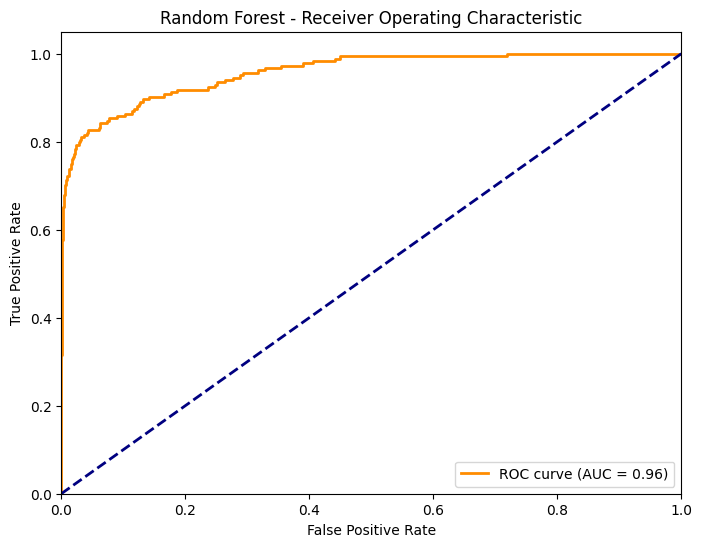

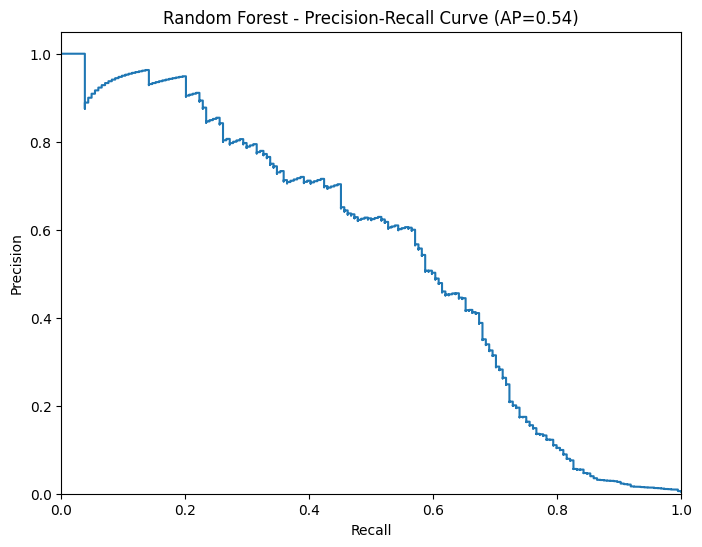


Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

  Legitimate       1.00      0.00      0.01     42598
       Fraud       0.00      1.00      0.01       184

    accuracy                           0.01     42782
   macro avg       0.50      0.50      0.01     42782
weighted avg       1.00      0.01      0.01     42782



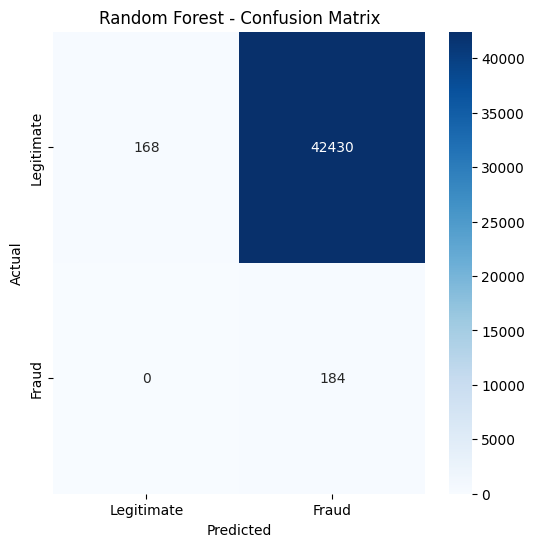

Fraud Detection Rate: 100.00%
False Positive Rate: 99.61%
Precision on Fraud Cases: 0.43%

===== XGBOOST EVALUATION =====
ROC-AUC Score: 0.9731


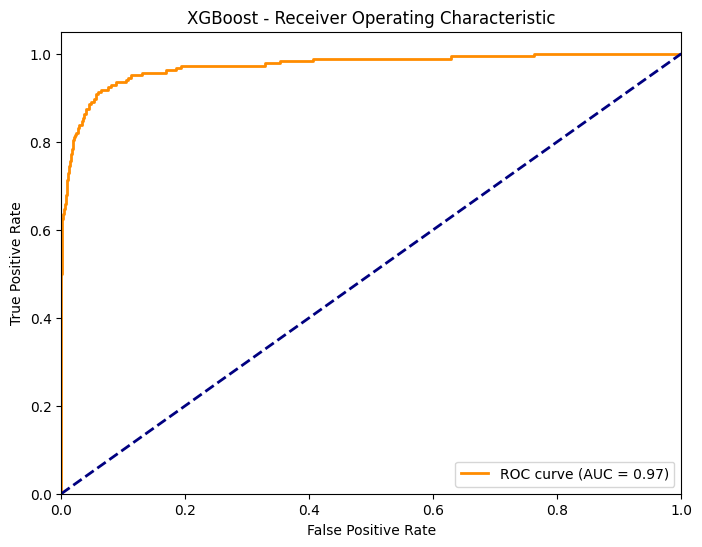

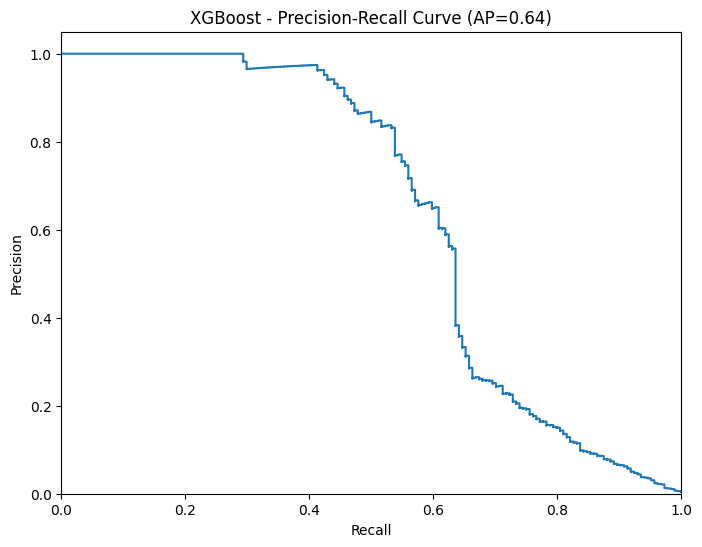


Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

  Legitimate       1.00      0.00      0.01     42598
       Fraud       0.00      1.00      0.01       184

    accuracy                           0.01     42782
   macro avg       0.50      0.50      0.01     42782
weighted avg       1.00      0.01      0.01     42782



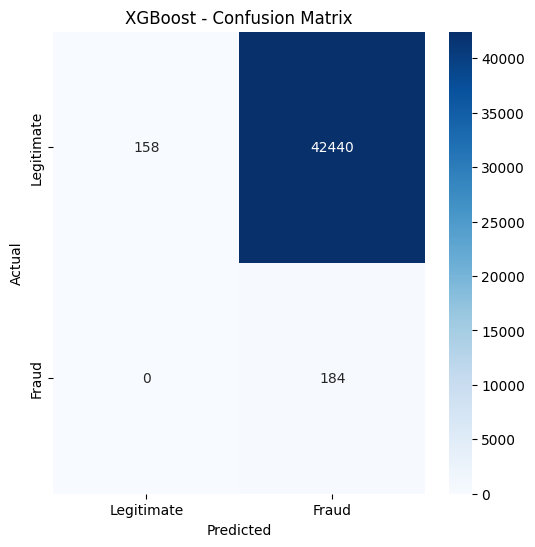

Fraud Detection Rate: 100.00%
False Positive Rate: 99.63%
Precision on Fraud Cases: 0.43%


In [43]:
# Evaluate models
rf_auc = evaluate_model("Random Forest", best_rf, X_test_processed, y_test)
xgb_auc = evaluate_model("XGBoost", best_xgb, X_test_processed, y_test)

### **Feature Importance**

In [44]:
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12, 8))
    plt.title(f"Top 20 Features - {title}")
    plt.barh(range(len(indices)), importances[indices][::-1], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices[::-1]])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

In [45]:
# Get feature names
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, cat_features])

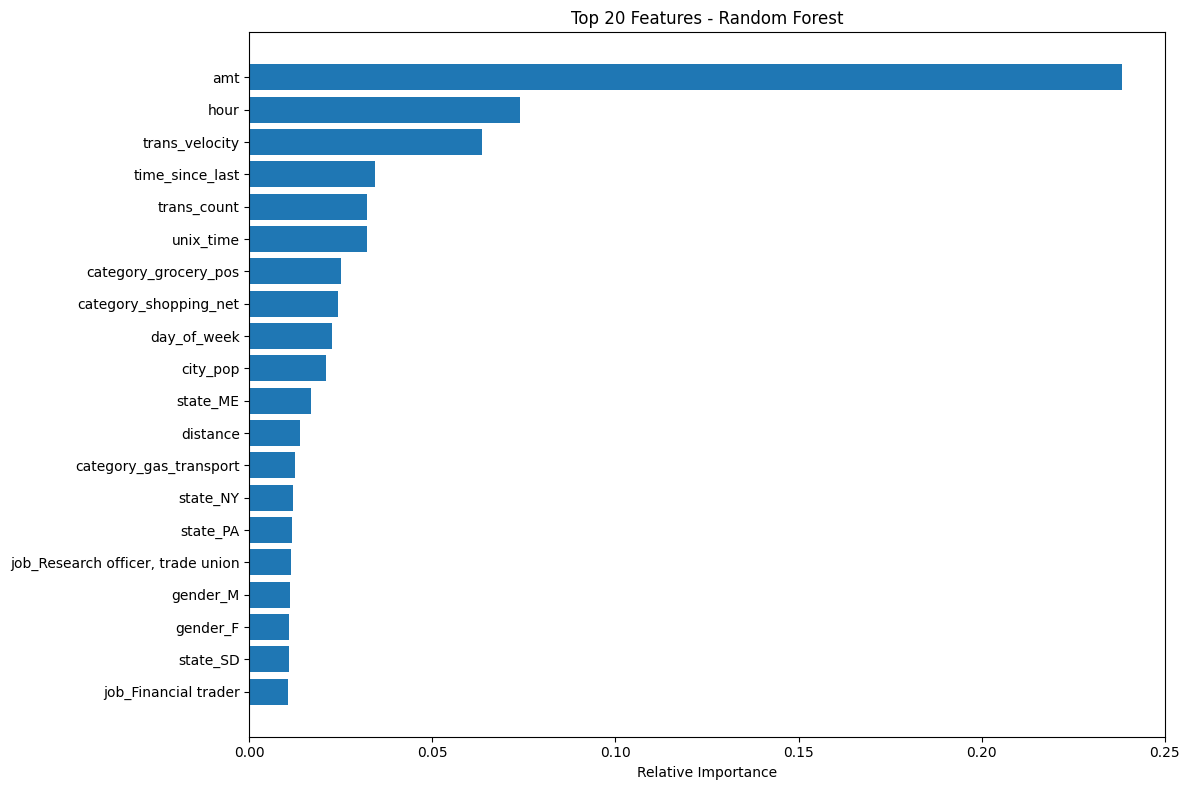

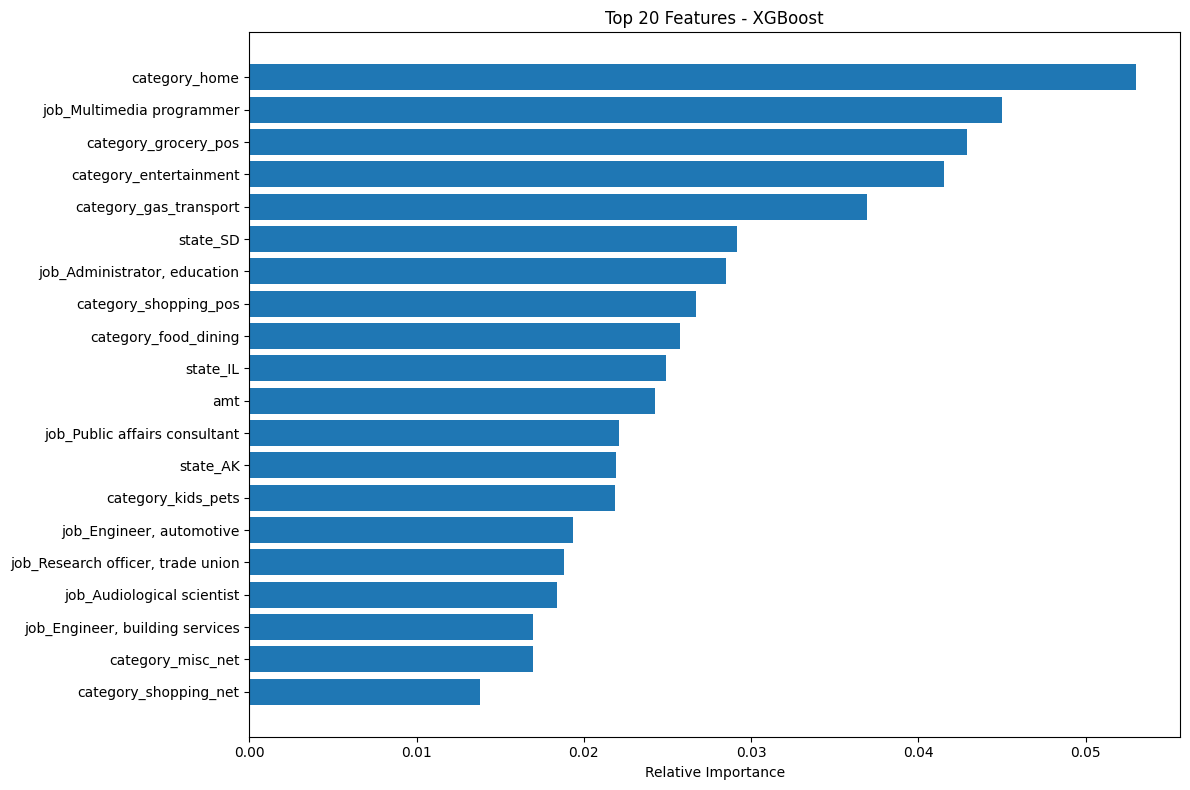

In [46]:
# Plot importances
plot_feature_importance(best_rf, all_features, "Random Forest")
plot_feature_importance(best_xgb, all_features, "XGBoost")

### **Model Persistence**

In [47]:
# Saving the best model
if rf_auc > xgb_auc:
    best_model = best_rf
    print(f"\nSaving Random Forest model with ROC-AUC: {rf_auc:.4f}")
else:
    best_model = best_xgb
    print(f"\nSaving XGBoost model with ROC-AUC: {xgb_auc:.4f}")

joblib.dump(best_model, 'fraud_detection_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("\n===== TRAINING COMPLETE =====")


Saving XGBoost model with ROC-AUC: 0.9731

===== TRAINING COMPLETE =====
